In [105]:
import pandas as pd
import numpy as np
from khaiii import KhaiiiApi
import gensim
import pyLDAvis.gensim
import numpy as np
import logging
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import time
from pprint import pprint

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
data = pd.read_csv("./modi_data/kor_full.csv") ############
#data = data.drop(['Unnamed: 0'], axis=1)
data.head()

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,no,year,title,kor_full
0,137,2002,탐색 알고리즘 교육을 위한 S/W 컴포넌트의 개발,"탐색 알고리즘 교육을 위한 S/W 컴포넌트의 개발 탐색알고리즘교육, 컴퓨터프로그래밍..."
1,147,2002,프로젝트 학습을 기반으로 하는 ICT 활용 수업 모형의 개발 및 적용,프로젝트 학습을 기반으로 하는 ICT 활용 수업 모형의 개발 및 적용 ICT 활용교...
2,148,2002,분산 컴퓨팅 환경에서의 웹 교육 컴포넌트 개발과정 모델링,"분산 컴퓨팅 환경에서의 웹 교육 컴포넌트 개발과정 모델링 웹기반 교육, 컴포넌트 개..."
3,149,2002,효과적인 아동용 WBI를 위한 한글 타이포그래피의 가해성 분석과 활용,효과적인 아동용 WBI를 위한 한글 타이포그래피의 가해성 분석과 활용 타이포 그래피...
4,150,2002,교수 · 학습 디지털 컨텐트 통합메타데이터 및 개체-관계 모델 설계,"교수 · 학습 디지털 컨텐트 통합메타데이터 및 개체-관계 모델 설계 교수.학습, 컨..."


In [107]:
dfWordList = pd.read_excel("./khaiii_word_cor.xlsx")
dfWordList2 = pd.read_excel("./khaiii_word_cor_etc.xlsx")
#print(dfWordList2)

dfWordDel = dfWordList[dfWordList["수정"] == "삭제"]
dfWordMod = dfWordList[dfWordList["수정"] != "삭제"]
dfWordDiv = dfWordList2
#print(dfWordMod)

seriesDelete = dfWordDel["기존"]
stopword = []
for word in seriesDelete.values:
    stopword.append(word)
#print(stopword)

seriesModify = dfWordMod["기존"]
modiword = []
for word in seriesModify.values:
    modiword.append(word)
#print(len(modiword))

seriesModify2 = dfWordMod["수정"]
modiword2 = []
for word in seriesModify2.values:
    modiword2.append(word)
#print(len(modiword2))

seriesDivide = dfWordDiv["기존"]
divword = []
for word in seriesDivide.values:
    divword.append(word)
#print(divword)
#print(len(divword))

seriesDivide2 = dfWordDiv["수정"]
divword2 = []
for words in seriesDivide2.values:
    divword2.append(words.split(', '))
#print(divword2)
#print(len(divword2))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
api = KhaiiiApi()
def khaiiiTokenizer(raw, stopword=stopword, pos=['NNG', 'NNP', 'NNB', 'NP', 'NR', 'SL']): # 일반명사 고유명사 의존명사 대명사 수사 외국어
    list = []
    skip = 0

    for word in api.analyze(raw): #raw data
        #print(word)
        
        for i, morph in enumerate(word.morphs):
            #print(morph.lex)
            if skip == 1: 
                #print(morph.lex) # '지능'
                skip = 0
                continue

            if morph.lex == '인공' and i+1 < len(word.morphs) and word.morphs[i+1].lex == "지능":
                #print(morph.lex + word.morphs[i+1].lex) # 인공지능
                list.append(morph.lex + word.morphs[i+1].lex)
                skip = 1
                continue

            if len(morph.lex) > 1 and morph.tag in pos and morph.lex not in stopword: 
                if morph.tag == 'SL':
                    morph.lex = morph.lex.lower()
                if morph.lex in divword:
                    morph.lex = divword2[divword.index(morph.lex)]
                    list.extend(morph.lex)
                elif morph.lex in modiword:
                    morph.lex = modiword2[modiword.index(morph.lex)]
                    list.append(morph.lex)
                else: list.append(morph.lex)
                
    return list

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
tokenized = data["kor_full"].apply(lambda row: khaiiiTokenizer(row))
#print(tokenized)
tokenized.to_excel("./final_data/1211token_khaiii_full.xls") ##############
print("========= tokenization completed =========")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
========= tokenization completed =========


In [110]:
#lda
id2word = gensim.corpora.Dictionary(tokenized)

wordlist = []
for i in range(len(id2word)):
    #print(id2word[i])
    wordlist.append(id2word[i])
#print(wordlist)
seriesWordlist = pd.Series(wordlist)
seriesWordlist.to_excel("./final_data/1211wordlist_khaiii_full.xls") #################

corpus=[id2word.doc2bow(text) for text in tokenized]
#print("id2word for each document : ", corpus)
print("# words in total : ", len(id2word))
print("# documents : ", len(corpus))

# words in total :  4218
# documents :  812
/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_list.append(model)
        perplexitymodel = model.log_perplexity(corpus)
        perplexity_values.append(perplexitymodel)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, perplexity_values, coherence_values

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
start = time.time()
model_list, perplexity_values, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tokenized,
                                                        start=2,
                                                        limit=31, #####
                                                        step=1)
print("time : ", ( time.time() - start )/60, "min")

2
/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
time :  3.026193888982137 min


/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


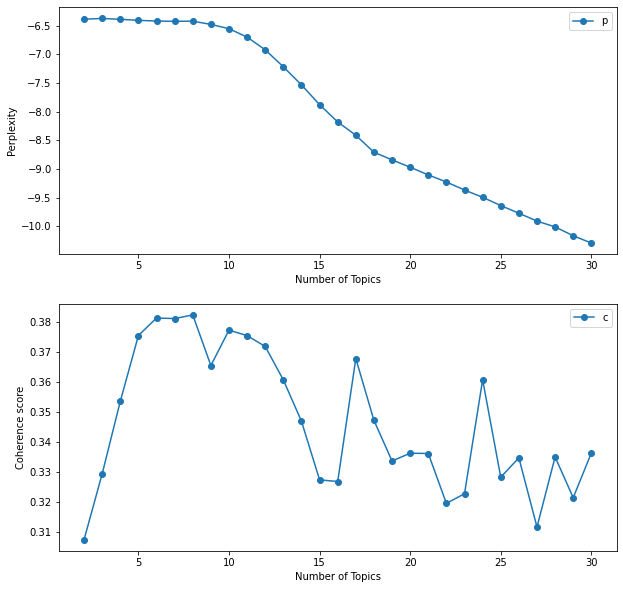

In [114]:
limit=31 ######
start=2
step=1
x = range(start, limit, step)


fig, ax = plt.subplots(2,1, figsize=(10, 10))

ax[0].plot(x, perplexity_values, marker='o')
ax[0].set_xlabel("Number of Topics")
ax[0].set_ylabel("Perplexity")
ax[0].legend(("perplexity"), loc='best')

ax[1].plot(x, coherence_values, marker='o')
ax[1].set_xlabel("Number of Topics")
ax[1].set_ylabel("Coherence score")
ax[1].legend(("coherence_values"), loc='best')
plt.show()

In [115]:
for m, pv in zip(x, perplexity_values):
  print("Num Topics =", m, " has Perplexity Value of", round(pv, 4))

for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Perplexity Value of -6.3901
Num Topics = 3  has Perplexity Value of -6.3767
Num Topics = 4  has Perplexity Value of -6.3919
Num Topics = 5  has Perplexity Value of -6.4095
Num Topics = 6  has Perplexity Value of -6.4228
Num Topics = 7  has Perplexity Value of -6.4266
Num Topics = 8  has Perplexity Value of -6.4245
Num Topics = 9  has Perplexity Value of -6.4807
Num Topics = 10  has Perplexity Value of -6.5556
Num Topics = 11  has Perplexity Value of -6.702
Num Topics = 12  has Perplexity Value of -6.9234
Num Topics = 13  has Perplexity Value of -7.2197
Num Topics = 14  has Perplexity Value of -7.5344
Num Topics = 15  has Perplexity Value of -7.879
Num Topics = 16  has Perplexity Value of -8.1798
Num Topics = 17  has Perplexity Value of -8.4119
Num Topics = 18  has Perplexity Value of -8.7083
Num Topics = 19  has Perplexity Value of -8.8397
Num Topics = 20  has Perplexity Value of -8.9694
Num Topics = 21  has Perplexity Value of -9.1022
Num Topics = 22  has Perplexit

In [116]:
a = int(input("set the number of topics "))
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=a,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(0,
  '0.094*"정보" + 0.039*"ict" + 0.029*"디지털" + 0.025*"능력" + 0.024*"학생" + '
  '0.021*"윤리" + 0.020*"통신" + 0.019*"비판" + 0.018*"리터러시" + 0.017*"매개" + '
  '0.016*"학교" + 0.015*"환경" + 0.015*"의사소통" + 0.014*"정책" + 0.014*"소속" + '
  '0.013*"학부모" + 0.013*"사회" + 0.012*"가상현실" + 0.011*"접근" + 0.011*"측정" + '
  '0.011*"하위" + 0.010*"사이버" + 0.010*"활용" + 0.009*"배경" + 0.009*"분석" + '
  '0.009*"초등" + 0.009*"요인" + 0.008*"수준" + 0.008*"논문" + 0.007*"pisa"'),
 (1,
  '0.135*"교육" + 0.039*"교사" + 0.037*"sw" + 0.032*"연구" + 0.028*"인공지능" + '
  '0.025*"과정" + 0.024*"분석" + 0.024*"역량" + 0.023*"정보" + 0.014*"내용" + 0.014*"활용" '
  '+ 0.013*"예비" + 0.012*"컴퓨터" + 0

In [117]:
title = input("set the title of html file ")
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, title+".html")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
# topic proportion
# num of optimal topics = 8

proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    proportion.append(row)
print(pd.DataFrame(proportion))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                    0                 1                 2                 3  \
0    (1, 0.028782021)    (2, 0.7778588)  (4, 0.023416162)   (6, 0.15789698)   
1     (0, 0.22645117)   (1, 0.08572954)   (2, 0.24743988)   (4, 0.33012244)   
2     (1, 0.14190781)   (2, 0.19381136)   (4, 0.15083544)    (6, 0.4899157)   
3     (1, 0.08731574)  (2, 0.056898814)    (4, 0.7123362)  (6, 0.043355267)   
4     (0, 0.07030365)   (1, 0.07289561)   (2, 0.27355835)   (4, 0.43748435)   
..                ...               ...               ...               ...   
807  (0, 0.014693867)    (1, 0.6122771)  (2, 0.036046226)  (3, 0.018962827

In [119]:
proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    inner_proportion = ["-", "-", "-", "-", "-", "-", "-", "-"] # numtopics 8
    for j, (topic_num, prop) in enumerate(row):
        for k in range(8): # numtopics 8
            if topic_num == k:
                inner_proportion[k] = prop
    proportion.append(inner_proportion)
    #print(inner_proportion)
#print(proportion)

#topic_proportions = pd.DataFrame(data["title"])

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
topic_proportions = pd.concat([data["title"], pd.DataFrame(proportion)], axis=1)
topic_proportions.columns = ["Title", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7"] #num topics = 8
print(topic_proportions)
topic_proportions.to_excel("./final_data/1210_topic_proportions_total.xlsx")

                                                 Title         T0         T1  \
0                          탐색 알고리즘 교육을 위한 S/W 컴포넌트의 개발          -  0.0287487   
1               프로젝트 학습을 기반으로 하는 ICT 활용 수업 모형의 개발 및 적용   0.226452  0.0857274   
2                      분산 컴퓨팅 환경에서의 웹 교육 컴포넌트 개발과정 모델링          -   0.141911   
3               효과적인 아동용 WBI를 위한 한글 타이포그래피의 가해성 분석과 활용          -  0.0873157   
4                교수 · 학습 디지털 컨텐트 통합메타데이터 및 개체-관계 모델 설계  0.0703036  0.0728959   
..                                                 ...        ...        ...   
807       R 매핑을 이용한 인공지능의 교육적 활용 탐색 - 국외 문헌 분석을 중심으로 -  0.0146941   0.612278   
808                 중학교 정보교과에서 짝 프로그래밍이 4Cs 향상에 미치는 영향  0.0902575  0.0151144   
809                         자동 분류 기술을 활용한 온라인 강의 평가 방법          -  0.0369069   
810               인공지능교육 역량 강화를 위한 교원 연수 프로그램과 교사 요구분석   0.028737   0.521573   
811  초·중등 현직 교원의 스크래치 활용 교수자료 개발에 대한 경험 분석 : ASSURE...          -   0.355361   

           T2         T3        T4     